In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import cv2
from tqdm import tqdm # process bar
from glob import glob
import os
import json

In [3]:
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

In [4]:
sample = 10123

sample_csv = pd.read_csv(f'../dataset/sample_data/{sample}/{sample}.csv')
sample_image = cv2.imread(f'../dataset/sample_data/{sample}/{sample}.jpg')

with open(f'../dataset/sample_data/{sample}/{sample}.json', 'r') as f:
    sample_json = json.load(f)

In [5]:
# csv
sample_csv.head()

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-08-13 15:10:00,28.0,28.1,27.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,91.1,-,-
1,2021-08-13 15:00:00,28.2,28.3,28.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,97.5,-,-
2,2021-08-13 14:50:00,28.5,28.7,28.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,100.8,-,-
3,2021-08-13 14:40:00,28.9,29.0,28.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,109.5,-,-
4,2021-08-13 14:30:00,29.1,29.2,29.0,-,-,-,-,-,-,...,-,-,-,-,-,-,-,134.8,-,-


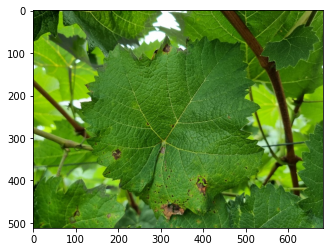

In [6]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
# json
sample_json

{'description': {'date': '20210813',
  'image': '10123.jpg',
  'task': 1,
  'width': 682,
  'time': '1514',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'a12',
  'grow': 24,
  'bbox': [{'x': 110.0120625,
    'h': 438.0925,
    'y': 57.31435416666667,
    'w': 435.45733333333334}],
  'part': [{'x': 277.92466666666667,
    'h': 53.62866666666667,
    'y': 439.8215416666667,
    'id': 0,
    'w': 84.996375},
   {'x': 377.08708333333334,
    'h': 54.30325,
    'y': 384.50641666666667,
    'id': 1,
    'w': 39.462625},
   {'x': 336.612625,
    'h': 32.716854166666664,
    'y': 65.43272916666666,
    'id': 2,
    'w': 30.693125},
   {'x': 180.111375,
    'h': 30.355854166666667,
    'y': 324.4693125,
    'id': 3,
    'w': 33.05414583333334},
   {'x': 303.55847916666664,
    'h': 33.39142708333333,
    'y': 75.88863541666667,
    'id': 4,
    'w': 24.95925},
   {'x': 256.47852083333333,
    'h': 37.71083333333333,
    'y': 415.9900416666667,
    'id': 5,
    'w': 

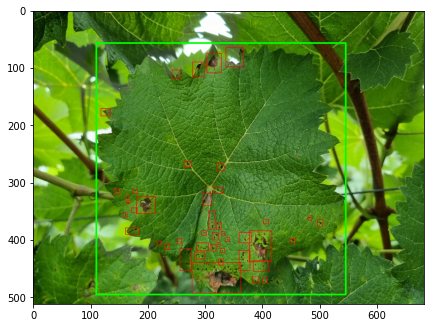

In [8]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0] # green
part_points = sample_json['annotations']['part'] # red
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x'] + points['w'])), int((points['y'] + points['h']))),
    (0, 255, 0),
    2
)

for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

## 데이터 로드

### 환경 데이터 통계량 계산 for MinMax Scaling

참고) https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=demian7607&logNo=222009975984

In [9]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('../dataset/sample_data/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature별 최대값, 최소값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr, temp_max], axis=0)
    min_arr = np.min([min_arr, temp_min], axis=0)
    
# feature 별 최대값, 최소값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:07<00:00, 67.53it/s]


{'내부 온도 1 평균': [14.4, 47.3],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 이슬점 평균': [12.4, 29.9],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1]}

### CustomDataset 제작

In [10]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = -1 * 24*6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        json_path = f'{file}/{file_name}.json'
        image_path = f'{file}/{file_name}.jpg'
        
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)

            # MinMax scaling
            for col in self.csv_feature_dict.keys():
                df[col] = df[col] - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            
            # transpose to sequential data
            csv_feature = df[self.csv_feature_dict.keys()].to_numpy()[self.max_len:].T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }          

### 하이퍼파라미터 및 변수

In [77]:
device = torch.device('cpu')
batch_size = 50
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 30
vision_pretrain = True
save_path = 'best_model.pt'

### 데이터셋 구성

In [78]:
data_files = glob('../dataset/sample_data/*')

train = data_files[:250]
val = data_files[250:]

In [79]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

## 모델

### 이미지 분류 모델: Resnet50

In [80]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained = True)
        
    def forward(self, inputs):
        output = self.model(inputs)
        return output

### 시계열 모델: LSTM

In [81]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim = 1) # enc_out + hidden
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

### 앙상블

In [82]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [83]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

## 학습

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [85]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model, save_path)

0it [00:00, ?it/s]c:\python\python38\lib\site-packages\torch\cuda\amp\autocast_mode.py:117: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
1it [00:42, 42.33s/it, Epoch=1, Loss=3.061209, Mean Loss=3.061209, Mean F-1=0.028606]c:\python\python38\lib\site-packages\torch\cuda\amp\autocast_mode.py:117: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
2it [01:15, 37.01s/it, Epoch=1, Loss=2.177173, Mean Loss=2.619191, Mean F-1=0.072384]c:\python\python38\lib\site-packages\torch\cuda\amp\autocast_mode.py:117: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not ava